In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
%matplotlib inline

In [2]:
# real (and unknown) parameter
real_tau = 0.8

# possible range of values for tau
tau_support = 0,1

In [3]:
class TModel:
        
    poisson_A = stats.poisson(2)
    poisson_B = stats.poisson(4)

    def __init__(self, tau):        
        assert tau>=0 and tau<=1        
        self.tau = tau
        
    def rvs(self, n):
        n1 = int(n*self.tau)        
        r = list(self.poisson_A.rvs(n1)) + list(self.poisson_B.rvs(n - n1))
        return r
    
    def logprob(self, x):
        n = int(len(x)*self.tau)
        return np.sum(np.log(self.poisson_A.pmf(x[:n]))) + np.sum(np.log(self.poisson_B.pmf(x[n:])))    
         

# Our observations


In [141]:
x = TModel(tau=real_tau).rvs(300)

# use this small sample for comparisons with other notebooks
#x = [3, 3, 2, 3, 1, 1, 1, 1, 0, 1, 0, 2, 0, 2, 3, 2, 0, 3, 2, 2, 2, 2, 2, 1, 1, 5, 6, 2, 3, 4]


Text(0.5, 0, '$\\tau$')

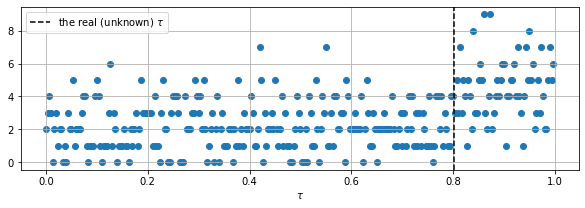

In [142]:
plt.figure(figsize=(10,3))
plt.scatter(np.arange(len(x))/len(x), x)
plt.axvline((real_tau*len(x)+.5)/len(x), ls="--", color="black", label=r"the real (unknown) $\tau$")
plt.grid(); plt.legend();
plt.xlabel(r"$\tau$")

# A variational model

In [143]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, InputLayer
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [144]:
def log_likelihood(x, tau):
    lambda_A, lambda_B = 2., 4.

    n = len(x)
    n1 = tf.cast(tf.cast(n, tf.float32)*tau, tf.int32)

    lambdas = tf.concat([tf.ones(n1)*lambda_A, tf.ones(n-n1)*lambda_B], 0)

    return tf.reduce_sum(tfd.Poisson(rate=lambdas).log_prob(x))

we want $q(\tau)$ which is an approximation for $P(\tau|X)$

$$q(\tau) \approx P(\tau|X) = \frac{P(X|\tau)P(\tau)}{P(X)} $$

so we maximixe the ELBO

$$\underset{\theta}{\text{arg max}}\;\; \mathbb{E}_{q_\theta(z)}\Big[\log P(X|\tau)\Big] - \text{KL}\Big[q_\theta(\tau)|P(\tau)\Big]$$

$$\underset{\theta}{\text{arg max}}\;\; \int q_\theta(z) \log P(X|\tau) d\tau - \int q_\theta(\tau) \log \frac{q_\theta(\tau)}{P(\tau)} d\tau$$

$$\underset{\theta}{\text{arg max}}\;\; \int \Big[ q_\theta(z) \log P(X|\tau)\Big] d\tau - \int q_\theta(\tau) \Big[ \log q_\theta(\tau)- \log P(\tau) \Big] d\tau$$

We'll do naive numerical integration splitting the interval $[0,1]$ for $\tau$ and summing up. Also, since we are using a uniform uninformative prior $P(\tau)=1$ and $\log P(\tau) = 0$

$$\underset{\theta}{\text{arg max}}\;\; \sum q_\theta(z) \log P(X|\tau) \Delta\tau - \sum q_\theta(\tau) \log q_\theta(\tau)  \Delta\tau$$


In [145]:
rtau = np.linspace(0,1,100)
dtau = rtau[1] - rtau[0]

0.48427681971077974

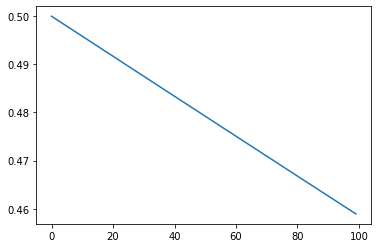

In [158]:
q = Sequential( [
    InputLayer(1),
    Dense(20, activation="relu"),
    Dense(1, activation="sigmoid")
    
])
ptau = q(rtau).numpy()[:,0]
plt.plot(ptau)
np.sum(ptau)*dtau


In [159]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.05)

In [160]:
for epoch in range(50):
    with tf.GradientTape() as t:
        lz   = tf.convert_to_tensor(np.r_[[log_likelihood(x, tau) for tau in rtau]].reshape(-1,1))  
        qz   = q(rtau)
        loss = -tf.reduce_sum(lz*qz*dtau - qz*tf.math.log(qz)*dtau)

    print (f"epoch {epoch:3d} loss: {loss:+.5f}")
    grads = t.gradient(loss, q.trainable_variables)
    optimizer.apply_gradients(zip(grads, q.trainable_variables))


epoch   0 loss: +28684.06641
epoch   1 loss: +24716.78711
epoch   2 loss: +20561.88867
epoch   3 loss: +16378.88867
epoch   4 loss: +12430.28809
epoch   5 loss: +8969.72168
epoch   6 loss: +6171.31201
epoch   7 loss: +4080.33301
epoch   8 loss: +2623.29736
epoch   9 loss: +1660.90747
epoch  10 loss: +1047.71179
epoch  11 loss: +664.72168
epoch  12 loss: +427.13260
epoch  13 loss: +279.29263
epoch  14 loss: +186.38205
epoch  15 loss: +127.14396
epoch  16 loss: +88.72098
epoch  17 loss: +63.32981
epoch  18 loss: +46.22371
epoch  19 loss: +34.47432
epoch  20 loss: +26.24947
epoch  21 loss: +20.38504
epoch  22 loss: +16.12926
epoch  23 loss: +12.98864
epoch  24 loss: +10.63394
epoch  25 loss: +8.84194
epoch  26 loss: +7.45898
epoch  27 loss: +6.37763
epoch  28 loss: +5.52175
epoch  29 loss: +4.83661
epoch  30 loss: +4.28235
epoch  31 loss: +3.82957
epoch  32 loss: +3.45635
epoch  33 loss: +3.14613
epoch  34 loss: +2.88629
epoch  35 loss: +2.66710
epoch  36 loss: +2.48098
epoch  37 loss: +2

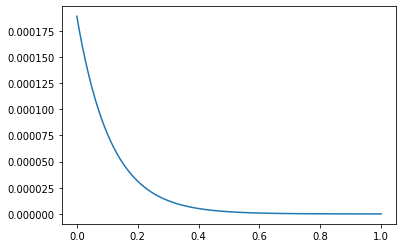

In [161]:
ptau = q(rtau).numpy()[:,0]
plt.plot(rtau, ptau)

In [162]:
np.sum(ptau)*dtau

2.196224904948413e-05